In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files

In [3]:
import io
uploaded=files.upload()

Saving Churn For Clustering.csv to Churn For Clustering.csv


In [4]:
churn_o = pd.read_csv(io.BytesIO(uploaded["Churn For Clustering.csv"]))
churn_o.head(10)

,Churn,Tenure,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device
0,1,4.0,3.0,6.0,Debit Card,Female,3.0,3.0,Super,2.0,Single,9.0,1.0,11.0,1.0,5.0,159.93,Mobile
1,1,0.0,1.0,8.0,UPI,Male,3.0,4.0,Regular Plus,3.0,Single,7.0,1.0,15.0,0.0,0.0,120.90,Mobile
2,1,0.0,1.0,30.0,Debit Card,Male,2.0,4.0,Regular Plus,3.0,Single,6.0,1.0,14.0,0.0,3.0,NaN,Mobile
3,1,0.0,3.0,15.0,Debit Card,Male,2.0,4.0,Super,5.0,Single,8.0,0.0,23.0,0.0,3.0,134.07,Mobile
4,1,0.0,1.0,12.0,Credit Card,Male,2.0,3.0,Regular Plus,5.0,Single,3.0,0.0,11.0,1.0,3.0,129.60,Mobile
5,1,0.0,1.0,22.0,Debit Card,Female,3.0,NaN,Regular Plus,5.0,Single,2.0,1.0,22.0,4.0,7.0,139.19,Computer
6,1,2.0,3.0,11.0,Cash on Delivery,Male,2.0,3.0,Super,2.0,Divorced,4.0,0.0,14.0,0.0,0.0,120.86,Mobile
7,1,0.0,1.0,6.0,Credit Card,Male,3.0,3.0,Regular Plus,2.0,Divorced,3.0,1.0,16.0,2.0,0.0,122.93,Mobile
8,1,13.0,3.0,9.0,E wallet,Male,2.0,4.0,Regular Plus,3.0,Divorced,2.0,1.0,14.0,0.0,2.0,126.83,Mobile
9,1,0.0,1.0,31.0,Debit Card,Male,2.0,5.0,Regular Plus,3.0,Single,2.0,0.0,12.0,1.0,1.0,122.93,Mobile


In [5]:
churn_o.shape

(11260, 18)

In [6]:
churn=churn_o.copy()

In [7]:
# Clustering/Data Models in Python can take only numerical / categorical colums. It cannot take string / object types. 
# Converting object variables into numerical datatypes
for feature in churn.columns: 
    if churn[feature].dtype == 'object': 
        churn[feature] = pd.Categorical(churn[feature]).codes

In [8]:
churn.head()

,Churn,Tenure,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device
0,1,4.0,3.0,6.0,2,0,3.0,3.0,3,2.0,2,9.0,1.0,11.0,1.0,5.0,159.93,1
1,1,0.0,1.0,8.0,4,1,3.0,4.0,2,3.0,2,7.0,1.0,15.0,0.0,0.0,120.90,1
2,1,0.0,1.0,30.0,2,1,2.0,4.0,2,3.0,2,6.0,1.0,14.0,0.0,3.0,NaN,1
3,1,0.0,3.0,15.0,2,1,2.0,4.0,3,5.0,2,8.0,0.0,23.0,0.0,3.0,134.07,1
4,1,0.0,1.0,12.0,1,1,2.0,3.0,2,5.0,2,3.0,0.0,11.0,1.0,3.0,129.60,1


## <font color = "Blue"><b>Null Values Imputation:

#### <font color = "Red"><b> KNN Imputation Method to impute missing values 

In [9]:
from sklearn.impute import KNNImputer
imputer=KNNImputer(n_neighbors=3)

In [10]:
cols=churn.columns

In [11]:
churn_treated=pd.DataFrame(imputer.fit_transform(churn),columns=cols)

In [12]:
churn_treated.isnull().sum()

Churn                      0
Tenure                     0
City_Tier                  0
CC_Contacted_LY            0
Payment                    0
Gender                     0
Service_Score              0
Account_user_count         0
account_segment            0
CC_Agent_Score             0
Marital_Status             0
rev_per_month              0
Complain_ly                0
rev_growth_yoy             0
coupon_used_for_payment    0
Day_Since_CC_connect       0
cashback                   0
Login_device               0
dtype: int64

## <font color = "Blue"><b>Outlier Treatment:

In [13]:
def remove_outlier(col):
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range

In [14]:
out_col=['Tenure','CC_Contacted_LY','Account_user_count','rev_per_month','Day_Since_CC_connect','cashback']

In [15]:
for i in range(0,len(out_col)):
  lr,ur=remove_outlier(churn_treated[out_col[i]])
  churn_treated[out_col[i]]=np.where(churn_treated[out_col[i]]>ur,ur,churn_treated[out_col[i]])
  churn_treated[out_col[i]]=np.where(churn_treated[out_col[i]]<lr,lr,churn_treated[out_col[i]])

(array([1, 2, 3, 4, 5, 6]), <a list of 6 Text major ticklabel objects>)

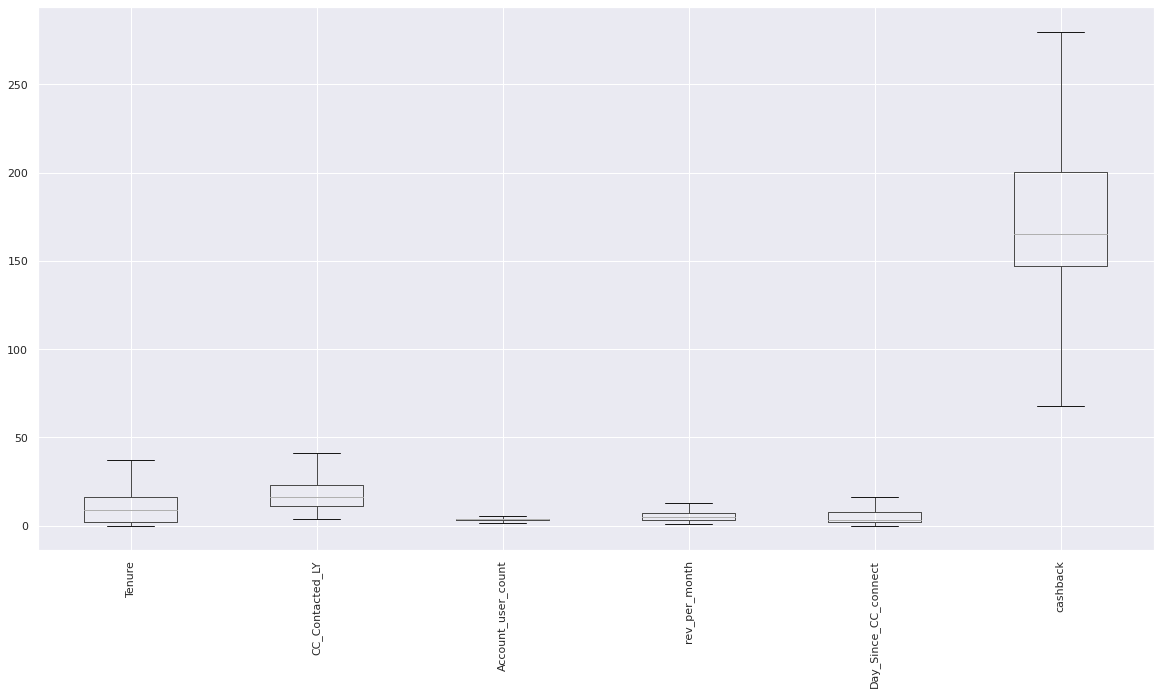

In [16]:
churn_treated[out_col].boxplot(figsize=(20,10))
plt.xticks(rotation=90)

#### <font color = "Red"><b> Standard Scaling the data

In [17]:
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler() 
num_cols = churn_treated.columns
churn_scaled=churn_treated.copy()
for i in num_cols:
    scale = StandardScaler().fit(churn_scaled[[i]])
    churn_scaled[i] = scale.transform(churn_scaled[[i]])

# <font color = "Blue"> <B> Creating Clusters using KMeans

### <font color = "Red"> <B> Calculating WSS for values K= 1 to 10 of K - Elbow Method

In [18]:
wss =[]
for i in range(1,11):
    KM = KMeans(n_clusters=i)
    KM.fit(churn_scaled)
    wss.append(KM.inertia_)

In [19]:
wss

[202680.0,
 186947.40602102724,
 175294.45552457633,
 168461.4472599914,
 162369.24618760444,
 157619.40431841035,
 153840.37869898847,
 150250.50257223434,
 147706.98129001187,
 145630.5301110589]

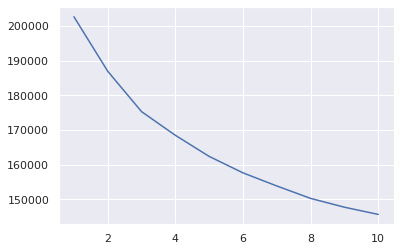

In [20]:
plt.plot(range(1,11), wss)

### <font color="Green">**From the elbow plot, slop of the plot starts reducing from K=3, however lets check for k=3and k=, silhouette score to be checked for deciding number vof clusters 

### <font color = "Red"> <B> KMeans with K= 3

In [21]:
k_means = KMeans(n_clusters = 3)
k_means.fit(churn_scaled)
labels_k3 = k_means.labels_

In [22]:
# Calculating silhouette_score
silhouette_score(churn_scaled,labels_k3)

0.08941684987443733

### <font color = "Red"> <B> KMeans with K= 4

In [23]:
k_means = KMeans(n_clusters = 4,random_state=0)
k_means.fit(churn_scaled)
labels_k4 = k_means.labels_

In [24]:
silhouette_score(churn_scaled,labels_k4)

0.07965634294758576

### <font color = "Red"> <B>Silhouette Score for K= 2 to 11

In [25]:
sil_score =[]
for i in range(2,11):
    k_means = KMeans(n_clusters = i,random_state=0)
    k_means.fit(churn_scaled)
    labels = k_means.labels_
    sil=silhouette_score(churn_scaled,labels)
    sil_score.append(sil)
  

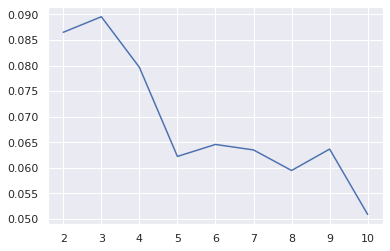

In [26]:
#silhouette_score Plot
plt.plot(range(2,11), sil_score);

##### <font color="Green"> Silhouette score is better for 3 clusters than for 4 clusters.
##### <font color="Green"> Same is evident from WSS plot,since values of wss drops drastically till the number of clusters are limited to 3. 
##### <font color="Green">So, final clusters will be 3

### <font color = "Red"> <B> Clustering Profiles based on K=3

In [27]:
#Renaming City_Tier values to Tier_1, Tier_2,Tier_3
churn_o['City_Tier']=churn_o['City_Tier'].replace({1:'Tier_1',2:'Tier_2',3:'Tier_3'})

In [28]:
churn_clustered=churn_o.copy()
churn_clustered["Clus_Profile"] = labels_k3
churn_clustered.head()

,Churn,Tenure,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device,Clus_Profile
0,1,4.0,Tier_3,6.0,Debit Card,Female,3.0,3.0,Super,2.0,Single,9.0,1.0,11.0,1.0,5.0,159.93,Mobile,1
1,1,0.0,Tier_1,8.0,UPI,Male,3.0,4.0,Regular Plus,3.0,Single,7.0,1.0,15.0,0.0,0.0,120.90,Mobile,1
2,1,0.0,Tier_1,30.0,Debit Card,Male,2.0,4.0,Regular Plus,3.0,Single,6.0,1.0,14.0,0.0,3.0,NaN,Mobile,1
3,1,0.0,Tier_3,15.0,Debit Card,Male,2.0,4.0,Super,5.0,Single,8.0,0.0,23.0,0.0,3.0,134.07,Mobile,1
4,1,0.0,Tier_1,12.0,Credit Card,Male,2.0,3.0,Regular Plus,5.0,Single,3.0,0.0,11.0,1.0,3.0,129.60,Mobile,1


In [29]:
churn_clustered.Clus_Profile.value_counts().sort_index()

0    5709
1    1801
2    3750
Name: Clus_Profile, dtype: int64

# <font color = "Blue"> <B>  Clustering Profiles

## <font color = "Green"> <B><i>  Profile 1

In [30]:
Clus_Prof_0=churn_clustered[churn_clustered.Clus_Profile==0].reset_index().drop('index',axis=1)
Clus_Prof_0.head()

,Churn,Tenure,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device,Clus_Profile
0,0,8.0,Tier_3,6.0,E wallet,Male,3.0,3.0,HNI,4.0,Divorced,2.0,0.0,13.0,1.0,6.0,172.95,Mobile,0
1,0,26.0,Tier_3,12.0,E wallet,Male,2.0,3.0,Super,3.0,Divorced,3.0,1.0,20.0,0.0,5.0,123.06,Mobile,0
2,0,18.0,Tier_1,15.0,Debit Card,Male,2.0,3.0,Super,4.0,Married,9.0,0.0,18.0,1.0,15.0,123.48,Mobile,0
3,0,5.0,Tier_3,14.0,E wallet,Female,2.0,3.0,HNI,2.0,Single,2.0,0.0,14.0,2.0,7.0,189.98,Computer,0
4,0,2.0,Tier_1,6.0,Cash on Delivery,Male,2.0,3.0,Super,3.0,Divorced,2.0,0.0,13.0,0.0,NaN,143.19,Computer,0


## <font color = "Green"> <i> Lets check the numbers for customers who have churned or not from Profile 1

In [31]:
Clus_Prof_0.Churn.value_counts().sort_values()

0    5709
Name: Churn, dtype: int64

### <font color = "Red"> <B> <i><b> As observed none of the customers from Profile 1 have churned

In [32]:
#Lets get the summary of the customers from Profile 1
Clus_Prof_0[Clus_Prof_0.Churn==0].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Churn,5709,NaN,NaN,NaN,0,0,0,0,0,0,0
Tenure,5589,NaN,NaN,NaN,8.64394,10.0005,0,2,7,12,99
City_Tier,5658,3,Tier_1,3847,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CC_Contacted_LY,5656,NaN,NaN,NaN,17.0069,8.67944,5,11,15,21,132
Payment,5646,5,Debit Card,2402,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,5700,2,Male,3598,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Service_Score,5657,NaN,NaN,NaN,2.72706,0.699387,0,2,3,3,5
Account_user_count,5471,NaN,NaN,NaN,3.43063,1.02093,1,3,3,4,6
account_segment,5675,5,Regular Plus,2664,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CC_Agent_Score,5646,NaN,NaN,NaN,2.92295,1.37609,1,2,3,4,5


## <font color = "Green"> <B><i> Profile 2

In [33]:
Clus_Prof_1=churn_clustered[churn_clustered.Clus_Profile==1].reset_index().drop('index',axis=1)
Clus_Prof_1.head()

,Churn,Tenure,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device,Clus_Profile
0,1,4.0,Tier_3,6.0,Debit Card,Female,3.0,3.0,Super,2.0,Single,9.0,1.0,11.0,1.0,5.0,159.93,Mobile,1
1,1,0.0,Tier_1,8.0,UPI,Male,3.0,4.0,Regular Plus,3.0,Single,7.0,1.0,15.0,0.0,0.0,120.90,Mobile,1
2,1,0.0,Tier_1,30.0,Debit Card,Male,2.0,4.0,Regular Plus,3.0,Single,6.0,1.0,14.0,0.0,3.0,NaN,Mobile,1
3,1,0.0,Tier_3,15.0,Debit Card,Male,2.0,4.0,Super,5.0,Single,8.0,0.0,23.0,0.0,3.0,134.07,Mobile,1
4,1,0.0,Tier_1,12.0,Credit Card,Male,2.0,3.0,Regular Plus,5.0,Single,3.0,0.0,11.0,1.0,3.0,129.60,Mobile,1


## <font color = "Green"> <i> Lets check the numbers for customers who have churned or not from Profile 2

In [34]:
Clus_Prof_1.Churn.value_counts().sort_values()

1    1801
Name: Churn, dtype: int64

### <font color = "Red"> <B> <i><b> As observed all the customers from Profile 2 have churned

In [35]:
#Lets get the summary of the customers from Profile 2
Clus_Prof_1[Clus_Prof_1.Churn==1].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Churn,1801,NaN,NaN,NaN,1,0,1,1,1,1,1
Tenure,1755,NaN,NaN,NaN,3.35214,9.75493,0,0,1,1,99
City_Tier,1786,3,Tier_1,998,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CC_Contacted_LY,1784,NaN,NaN,NaN,19.449,8.93723,4,12,17,26,43
Payment,1780,5,Debit Card,671,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,1781,2,Male,1135,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Service_Score,1785,NaN,NaN,NaN,2.90476,0.703056,2,2,3,3,4
Account_user_count,1737,NaN,NaN,NaN,3.91249,1.0145,1,3,4,5,6
account_segment,1783,5,Regular Plus,1119,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CC_Agent_Score,1780,NaN,NaN,NaN,3.40337,1.33622,1,3,3,5,5


## <font color = "Green"> <B><i> Profile 3

In [36]:
Clus_Prof_2=churn_clustered[churn_clustered.Clus_Profile==2].reset_index().drop('index',axis=1)
Clus_Prof_2.head()

,Churn,Tenure,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device,Clus_Profile
0,1,4.0,NaN,18.0,Cash on Delivery,Female,2.0,3.0,Regular,3.0,Divorced,2.0,0.0,12.0,9.0,8.0,295.45,Mobile,2
1,1,20.0,Tier_1,29.0,Credit Card,Female,3.0,3.0,HNI,2.0,Divorced,2.0,0.0,12.0,11.0,6.0,203.12,Mobile,2
2,0,13.0,Tier_3,10.0,E wallet,Male,3.0,4.0,HNI,2.0,Divorced,8.0,0.0,11.0,2.0,11.0,208.55,Mobile,2
3,0,30.0,Tier_1,30.0,Debit Card,Male,2.0,2.0,HNI,2.0,Married,NaN,NaN,16.0,1.0,4.0,194.39,Mobile,2
4,0,23.0,Tier_1,17.0,Debit Card,Female,2.0,3.0,Regular,4.0,Single,4.0,0.0,15.0,2.0,4.0,299.26,Mobile,2


## <font color = "Green"> <i> Lets check the numbers for customers who have churned or not from Profile 3

In [37]:
Clus_Prof_2.Churn.value_counts().sort_values()

1      95
0    3655
Name: Churn, dtype: int64

### <font color = "Red"> <B> <i><b> As observed Profile 3 consists of mix of people who have churned and also those who have not churned

In [38]:
#Lets get the summary of the customers from Profile 3 who have not churned
Clus_Prof_2[Clus_Prof_2.Churn==0].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Churn,3655,NaN,NaN,NaN,0,0,0,0,0,0,0
Tenure,3605,NaN,NaN,NaN,18.1501,13.9957,0,10,16,23,99
City_Tier,3611,3,Tier_1,2360,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CC_Contacted_LY,3624,NaN,NaN,NaN,18.4746,8.95142,5,12,16,24,43
Payment,3631,5,Debit Card,1483,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,3578,2,Male,1921,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Service_Score,3625,NaN,NaN,NaN,3.16883,0.694244,1,3,3,4,5
Account_user_count,3515,NaN,NaN,NaN,3.9744,0.918676,1,4,4,4,6
account_segment,3610,5,Super,1082,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CC_Agent_Score,3624,NaN,NaN,NaN,3.12224,1.3731,1,2,3,4,5


In [39]:
#Lets get the summary of the customers from Profile 3 who have churned
Clus_Prof_2[Clus_Prof_2.Churn==1].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Churn,95,NaN,NaN,NaN,1,0,1,1,1,1,1
Tenure,93,NaN,NaN,NaN,22.7312,27.4044,0,10,16,20,99
City_Tier,93,3,Tier_1,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CC_Contacted_LY,94,NaN,NaN,NaN,16.1809,7.69718,7,10.25,14,19,42
Payment,94,4,Credit Card,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,93,2,Male,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Service_Score,95,NaN,NaN,NaN,3.14737,0.683676,2,3,3,4,4
Account_user_count,93,NaN,NaN,NaN,4.37634,0.943098,2,4,4,5,6
account_segment,95,5,HNI,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CC_Agent_Score,94,NaN,NaN,NaN,3.15957,1.41652,1,2,3,4,5


### <font color = "Blue"> <b>4 b) Any business insights using clustering  (if applicable)

### <font color = "Green"> <b><i>•	People from Tier 3 City seems to be churning the most
### <font color = "Green"> <b><i>•	Customers who had to contact customer service more frequent around 15-25 times seems to be churning, this implies that they were not satisfied with the service provided.
### <font color = "Green"> <b><i>•	Accounts with around 4 users seems to be churning the most, which implies company can think of limiting the number of users per accounts
### <font color = "Green"> <b><i>•	Consumers who have received less coupons seems to be potential churners

### <font color = "Blue"> <b>Conclusion:

### <font color = "Green"> <b><i>•	Improvement of infrastructures in Tier 3 cities to provide better customer service.
### <font color = "Green"> <b><i>•	Run offers for the customers who are using Regular Plus accounts in terms of more cashback coupons, or add channel counts.